# Import relevant libraries

Imports the relevant python libraries needed.

In [1]:
import yahoo_fin
import yahoo_fin.stock_info as si
from yahoo_fin.stock_info import get_data
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt

# Import and preprocess data

Data is scraped from Yahoo!Finance for all S&P 500 companies using the yahoo_fin Python library.

The below extracts the list of S&P500 companies' tickers.

In [2]:
sp500_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', attrs={'class': 'wikitable sortable'},header=0)[0]['Symbol']
sp500_list.replace(to_replace='BRK.B',value='BRK-B',inplace=True)
sp500_list.replace(to_replace='BF.B',value='BF-B',inplace=True)

The below extracts the information from Yahoo!Finance according to the start date and end date specified. Information for each ticker is extracted for the 'daily' time interval.

In [3]:
#Variables created.
historical_data = {}
counter = 0
key_err = 0
assert_err = 0
tickers_key_err = []
tickers_assert_err= []

#User input - start date and end date
while True:
    try:
        start_date_input = input("Please enter START date for the date range you want the model to be trained on. Format of input: DD-MM-YY.")
        start_date = datetime.strptime(start_date_input, '%d-%m-%y')
        print("Start date: " + str(start_date_input))
        break
    except ValueError:
        print("                             ", end='\r')
        print("Please ensure input is in the format DD-MM-YY.", end='\r')

while True:
    try:
        end_date_input = input("Please enter END date for the date range you want the model to be trained on. Format of input: DD-MM-YY.")
        end_date = datetime.strptime(end_date_input, '%d-%m-%y')
        print("End date: " + str(end_date_input))
        break
    except ValueError:
        print("                             ", end='\r')
        print("Please ensure input is in the format DD-MM-YY.", end='\r')


for ticker in sp500_list:
    counter += 1
    print("                             ", end='\r')
    print(str(ticker) + " " + str(counter), end='\r')
    try:
        historical_data[ticker] = get_data(ticker, start_date = start_date_input, end_date = end_date_input)
        historical_data[ticker] = historical_data[ticker].drop(labels='ticker',axis=1)
        historical_data[ticker].columns = str(ticker) + "_" + historical_data[ticker].columns
        
    except KeyError:
        historical_data[ticker] = None
        key_err += 1
        tickers_key_err.append(ticker)
    except AssertionError:
        historical_data[ticker] = None
        assert_err += 1
        tickers_assert_err.append(ticker)
        
print("No. of stocks with data successfully generated: " + str(counter-key_err-assert_err) + ".")
print("No. of stocks with KeyError: " + str(key_err) + ".")
if key_err>0:
    print("Tickers with KeyError (to investigate if needed): " + str(tickers_key_err))
print("No. of stocks with AssertionError: " + str(assert_err) + ".")
if assert_err>0:
    print("Tickers with AssertionError (to investigate if needed): " + str(tickers_assert_err))

Please enter START date for the date range you want the model to be trained on. Format of input: DD-MM-YY.01-01-00
Start date: 01-01-00
Please enter END date for the date range you want the model to be trained on. Format of input: DD-MM-YY.30-11-20
End date: 30-11-20
No. of stocks with data successfully generated: 505.
No. of stocks with KeyError: 0.
No. of stocks with AssertionError: 0.


Merge the dictionary of dataframes column-wise on the index (which is the date). Drop all columns with NaN values.

In [4]:
merged_data = pd.concat(historical_data, axis=1)
merged_data = merged_data.dropna(axis='columns')
merged_tickers = list(set(merged_data.columns.get_level_values(0))) #Store all remaining tickers' names for further use later.
merged_data.columns = merged_data.columns.droplevel(0)

merged_data.head()



,MMM_open,MMM_high,MMM_low,MMM_close,MMM_adjclose,MMM_volume,ABT_open,ABT_high,ABT_low,ABT_close,...,ZBRA_low,ZBRA_close,ZBRA_adjclose,ZBRA_volume,ZION_open,ZION_high,ZION_low,ZION_close,ZION_adjclose,ZION_volume
2000-01-03,48.03125,48.25000,47.03125,47.1875,27.815882,2173400,15.823756,16.160431,15.599305,15.711531,...,24.777779,25.027779,25.027779,1055700,59.03125,59.1250,53.4375,55.5000,39.996193,1199600
2000-01-04,46.43750,47.40625,45.31250,45.3125,26.710594,2713800,15.459024,15.599305,15.150405,15.262630,...,23.000000,24.666666,24.666666,522400,54.62500,55.0000,52.5000,52.8125,38.059437,816100
2000-01-05,45.56250,48.12500,45.56250,46.6250,27.484299,3699400,15.066236,15.402911,15.066236,15.234573,...,23.555555,25.138889,25.138889,612100,52.75000,53.2500,51.0625,52.7500,38.014412,1124700
2000-01-06,47.15625,51.25000,47.15625,50.3750,29.694832,5975800,15.262630,15.823756,15.178461,15.767643,...,23.722221,23.777779,23.777779,263800,52.75000,54.9375,52.3750,53.5000,38.554890,1112100
2000-01-07,50.56250,51.90625,49.96875,51.3750,30.284302,4101200,15.487081,16.272657,15.487081,15.935981,...,23.111111,23.513889,23.513889,333900,53.75000,54.2500,53.3125,53.6250,38.644981,782000


In [5]:
print("List of all tickers in data: \n" + str(merged_tickers))
chosen_ticker = input("Indicate a ticker. Pick one from the print statement below.")
chosen_adjclose = chosen_ticker + "_adjclose"

List of all tickers in data: 
['MLM', 'PGR', 'WMB', 'CVX', 'F', 'HBAN', 'ETN', 'WMT', 'FRT', 'RMD', 'SIVB', 'PWR', 'EMN', 'AVB', 'EXPD', 'GPS', 'APH', 'MHK', 'PBCT', 'UPS', 'HOLX', 'LB', 'L', 'CTAS', 'CI', 'OKE', 'GE', 'KMB', 'CTXS', 'SBAC', 'BAC', 'DD', 'NI', 'TYL', 'EQR', 'HUM', 'DTE', 'ATVI', 'DXC', 'BIIB', 'WDC', 'WST', 'ALXN', 'PNR', 'MNST', 'INTU', 'IT', 'COO', 'STT', 'CHD', 'BIO', 'IFF', 'DLTR', 'GWW', 'TROW', 'NVDA', 'VAR', 'WELL', 'CMCSA', 'HAS', 'NOC', 'COST', 'COF', 'WM', 'LEN', 'JCI', 'ROK', 'SO', 'JBHT', 'XRX', 'CINF', 'AES', 'RJF', 'AMD', 'PH', 'WFC', 'ADI', 'FE', 'PAYX', 'CAH', 'PNW', 'ADBE', 'WRB', 'BKNG', 'J', 'PEAK', 'ESS', 'PCAR', 'HSY', 'MCD', 'KIM', 'AON', 'RTX', 'FFIV', 'CDNS', 'DE', 'BWA', 'NEM', 'CCL', 'LH', 'KR', 'HAL', 'NUE', 'GD', 'SPGI', 'IBM', 'MCK', 'EIX', 'ROST', 'VRSN', 'UNH', 'BRK-B', 'ABC', 'INTC', 'ALK', 'MU', 'WBA', 'OMC', 'JPM', 'HES', 'IVZ', 'ORLY', 'TJX', 'APA', 'KMX', 'ADP', 'USB', 'ALB', 'FAST', 'AMZN', 'SJM', 'KLAC', 'MCHP', 'BSX', 'AXP', 'BAX'

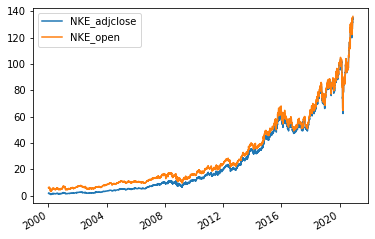

In [6]:

%matplotlib inline
merged_data[chosen_adjclose].plot()
merged_data[chosen_ticker+"_open"].plot()
plt.legend()

Pick variables based on the correlation coefficient of chosen_adjclose ("target variable") vs all other variables ("feature variables").

In [7]:
r = [np.corrcoef(merged_data[chosen_adjclose],merged_data[column])[0,1] for column in merged_data]
features = merged_data[merged_data.columns[np.argpartition(np.abs(r), -200)[-200:]]].shift(1).dropna()
target = merged_data[chosen_adjclose][1:]


Determine the proportion of the split between train and test set. Here, arbitrarily determined as 90% for training, 10% for testing. Note: For extremely large data sets, it may be good to specify a number value (as opposed to a percentage) for the test set as the test set need not be too large, and also it would be good for the training set to be larger where possible.


In [8]:
traintest_index = int(len(features) * 0.9) #This returns the row number for the boundary between train and test sets.
traintest_value = features.index[traintest_index] #This returns the datetimeindex at the row where we want to split between train and test sets.
features_train = features[features.index <= traintest_value]
features_test = features[features.index > traintest_value]
target_train = target[target.index <= traintest_value]
target_test = target[target.index > traintest_value]

print("Check of train-test split: ")
print("features = " + str(len(features)))
print("features_train = " + str(len(features_train)))
print("features_test = " + str(len(features_test)))


Check of train-test split: 
features = 5260
features_train = 4735
features_test = 525


Perform a min-max scaling on the features for both train and test sets using sklearn's MinMaxScaler module to ensure that data is all within the same scale.

In [9]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
features_train = pd.DataFrame(minmax_scaler.fit_transform(features_train), 
                              columns = features_train.columns, 
                              index = features_train.index)
features_train.head()

,INTU_low,SBUX_low,SBUX_open,ADP_adjclose,SBUX_close,APD_high,SBUX_high,JKHY_high,ATO_adjclose,LMT_adjclose,...,TYL_close,TYL_low,TYL_high,TYL_open,COST_adjclose,CHD_adjclose,CHD_close,TJX_adjclose,CHD_low,CHD_open
2000-01-04,0.072220,0.000255,0.000000,0.093282,0.001586,0.053217,0.000126,0.029817,0.025402,0.006382,...,0.019044,0.019478,0.019444,0.019715,0.056978,0.024776,0.032225,0.006696,0.030700,0.034800
2000-01-05,0.078406,0.001275,0.000379,0.093282,0.000000,0.046375,0.000506,0.029414,0.022889,0.007628,...,0.019545,0.019984,0.019693,0.019715,0.048931,0.023385,0.030425,0.005501,0.030519,0.031750
2000-01-06,0.089484,0.001147,0.000126,0.091331,0.000634,0.045234,0.000000,0.024974,0.026030,0.007855,...,0.020296,0.020490,0.019942,0.020215,0.051304,0.023385,0.030425,0.004868,0.030519,0.030315
2000-01-07,0.109050,0.001785,0.000253,0.094014,0.002410,0.063860,0.002023,0.027396,0.024460,0.008421,...,0.020296,0.020237,0.019942,0.020714,0.054141,0.025332,0.032945,0.006134,0.030700,0.029956
2000-01-10,0.094519,0.002294,0.001768,0.098649,0.002157,0.073363,0.000759,0.023965,0.025402,0.008535,...,0.019295,0.019225,0.019942,0.020464,0.063684,0.027557,0.035826,0.006696,0.033607,0.032468


In [10]:
!conda list

# packages in environment at C:\Users\hojun\anaconda3\envs\udac_MLE:
#
# Name                    Version                   Build  Channel
absl-py                   0.11.0                   pypi_0    pypi
alabaster                 0.7.12                     py_0  
anaconda                  2020.11                  py38_0  
anaconda-client           1.7.2                    py38_0  
anaconda-project          0.8.4                      py_0  
appdirs                   1.4.4                    pypi_0    pypi
argh                      0.26.2                   py38_0  
argon2-cffi               20.1.0           py38he774522_1  
asn1crypto                1.4.0                      py_0  
astroid                   2.4.2                    py38_0  
astropy                   4.0.2            py38he774522_0  
astunparse                1.6.3                    pypi_0    pypi
async_generator           1.10                       py_0  
atomicwrites              1.4.0                      py_0  
attr

In [11]:
features_test = pd.DataFrame(minmax_scaler.transform(features_test), 
                             columns=features_test.columns, 
                             index=features_test.index)
features_test.head()

,INTU_low,SBUX_low,SBUX_open,ADP_adjclose,SBUX_close,APD_high,SBUX_high,JKHY_high,ATO_adjclose,LMT_adjclose,...,TYL_close,TYL_low,TYL_high,TYL_open,COST_adjclose,CHD_adjclose,CHD_close,TJX_adjclose,CHD_low,CHD_open
2018-10-29,0.866585,0.889214,0.889923,0.887256,0.894456,0.840238,0.894646,0.912566,0.961030,0.856200,...,0.821411,0.827336,0.835529,0.817799,0.883871,0.960615,0.960250,0.948310,0.957623,0.971586
2018-10-30,0.852084,0.894272,0.900268,0.879579,0.899327,0.857463,0.916008,0.920961,0.970662,0.802785,...,0.818327,0.814223,0.840744,0.832693,0.902750,0.975170,0.974940,0.965148,0.969307,0.965903
2018-10-31,0.866171,0.894109,0.896227,0.893909,0.902899,0.862723,0.902900,0.906173,0.974094,0.815572,...,0.829422,0.818918,0.835529,0.814844,0.927297,0.998288,0.998272,0.981171,0.989362,0.976236
2018-11-01,0.892090,0.902593,0.905117,0.943774,0.897703,0.877121,0.906946,0.927225,0.955052,0.823651,...,0.843239,0.848828,0.854556,0.838523,0.930466,0.983561,0.983409,0.978545,0.979073,0.981746
2018-11-02,0.904612,0.900309,0.894125,0.920597,0.903549,0.879159,0.906136,0.927225,0.953502,0.839839,...,0.776514,0.772696,0.837599,0.832533,0.934795,1.077742,1.078464,0.980899,1.015521,1.003788


Sequence generation

In [12]:
sequence_length = 5
def gen_sequence(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

seq_array = np.array(list(gen_sequence(features_train,sequence_length)))
seq_array.shape

(4730, 5, 200)

In [13]:
def gen_labels(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

label_array = np.array(list(gen_labels(target_train,sequence_length)))
label_array.shape

(4730,)

In [14]:
seq_array_test = np.array(list(gen_sequence(features_test,sequence_length)))
seq_array_test.shape

(520, 5, 200)

In [15]:
label_array_test = np.array(list(gen_labels(target_test,sequence_length)))
label_array_test.shape

(520,)

# Benchmark Model - Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
linearregression = LinearRegression()
linearregression.fit(np.array([seq_array[i][sequence_length-1] for i in range(seq_array.shape[0])]),label_array)

LinearRegression()

In [17]:
prediction = linearregression.predict(np.array([seq_array_test[i][sequence_length-1] for i in range(seq_array_test.shape[0])]))


In [18]:
pd.DataFrame([prediction,label_array_test]).T\
.rename({0:'prediction',1:'truth'},axis=1)\
.set_index(target.index[target.index> target.index[int(len(target) * 0.9) + sequence_length]])\
.to_csv('LR_prediction.csv')

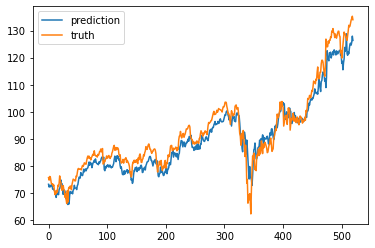

In [19]:
plt.plot(prediction, label='prediction')
plt.plot(label_array_test, label='truth')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(label_array_test,prediction),np.sqrt(mean_squared_error(label_array_test,prediction))

(0.922234153624434, 4.2500645037882565)

# Neural Network

LSTM model

In [22]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# build the network
nb_features = seq_array.shape[2]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='nadam', metrics=['mean_squared_error'])

ImportError: Traceback (most recent call last):
  File "C:\Users\hojun\anaconda3\envs\udac_MLE\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
model.summary()

In [ ]:
history = model.fit(seq_array, label_array, epochs=1000, batch_size=500, validation_split=0.1, verbose=0)

In [ ]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [ ]:
pd.DataFrame([history.history['loss'],history.history['val_loss']]).T\
.rename({0:'train',1:'test'},axis=1)\
.to_csv('history.csv')

In [ ]:
prediction = model.predict(seq_array_test)
plt.plot(prediction, label='prediction')
plt.plot(label_array_test, label='truth')
plt.legend()
plt.show()

In [ ]:

pd.DataFrame([np.squeeze(prediction),label_array_test]).T\
.rename({0:'prediction',1:'truth'},axis=1)\
.set_index(target.index[target.index>='2016-01-09'])\
.to_csv('LSTM_prediction.csv')